# Risk Distortion 
### Implicit Quantile Networks https://arxiv.org/pdf/1806.06923v1.pdf

In [1]:
import numpy as np
import torch
import torch.distributions as D
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

In [2]:
def cpw_distortion(n: float, tau: torch.Tensor):
    """
    Risk distortion based on cumulative probability weighting
    Referened in IQN paper, based on cumulative prospect theory.
    """
    num = tau**n
    denom = (tau**n + (1 - tau)**n)**1 / n
    return num / denom


def wang_distortion(n: float, tau: torch.Tensor):
    """
    Risk Distortion as per Wang 2002 (referenced in iqn paper).
    Inputs are clipped to prevent numerical instability in the icdf func
    """
    std_normal_dist = torch.distributions.Normal(0, 1)
    tau = torch.clip(tau, 1e-7, 1. - 1e-7)
    inv = std_normal_dist.icdf(tau) + n
    return std_normal_dist.cdf(inv)


def pow_distortion(n: float, tau: torch.Tensor):
    """ Power formula as in the IQN paper """
    if n < 0:
        return 1 - (1 - tau)**(1 / (1 + abs(n)))
    return tau**(1 / (1 + abs(n)))


def cvar_distortion(n: float, tau: torch.Tensor):
    """ Conditional Value at Risk"""
    return n * tau


In [3]:
p = torch.linspace(1e-7, 1-1e-7, 1000)
x = torch.linspace(-3, 3, 1000)


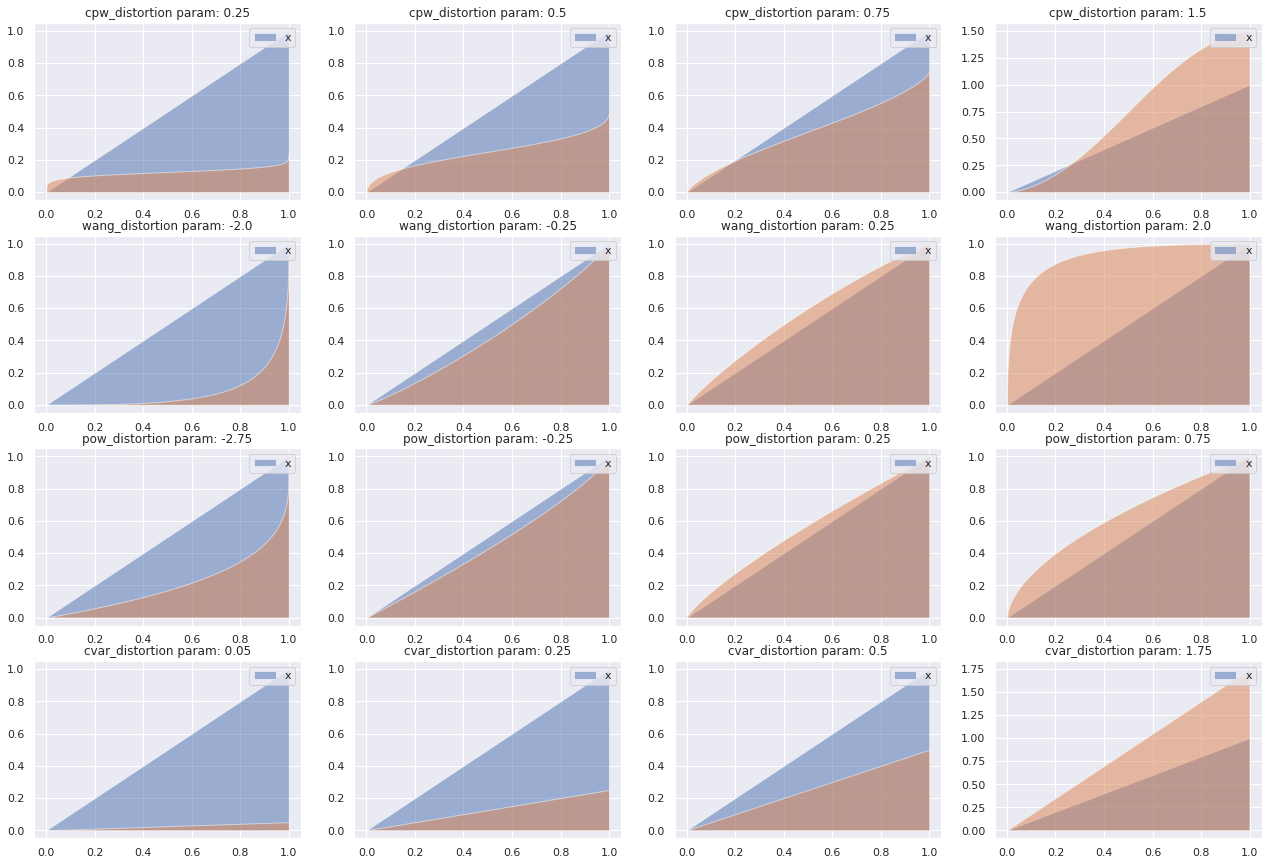

In [28]:
fig, ax = plt.subplots(4, 4, figsize = (22, 15))
for i, (func, params) in enumerate(((cpw_distortion, (.25, .5, .75, 1.5)), 
                                     (wang_distortion, (-2., -.25, .25, 2.)),
                                    (pow_distortion, (-2.75, -.25, .25, .75)),
                                    (cvar_distortion, (.05, .25, .5, 1.75))
                                    )):
    for j, param in enumerate(params):
        ax[i, j].fill_between(p, p, alpha=.5, label='x')
        ax[i, j].fill_between(p, func(param, p), alpha=.5)
#         ax.plot(x, func(param, x), label=f'{param}')
        ax[i, j].set_title(f'{func.__name__} param: {param}')
        ax[i, j].legend()
#     ax.legend()

In [5]:
def make_dist(x):
    dist1 = torch.distributions.Normal(0.5, .2).cdf(x)
    return dist1
dist = make_dist(p)
dist = torch.distributions.Normal(0, .1)
# dist = D.Normal(torch.tensor([.0, 1., -.1]), torch.tensor([.1, 0.02, 0.05]))
p = torch.linspace(1e-7, 1-1e-7, 1000)

In [6]:
dist.icdf(p).shape

torch.Size([1000])

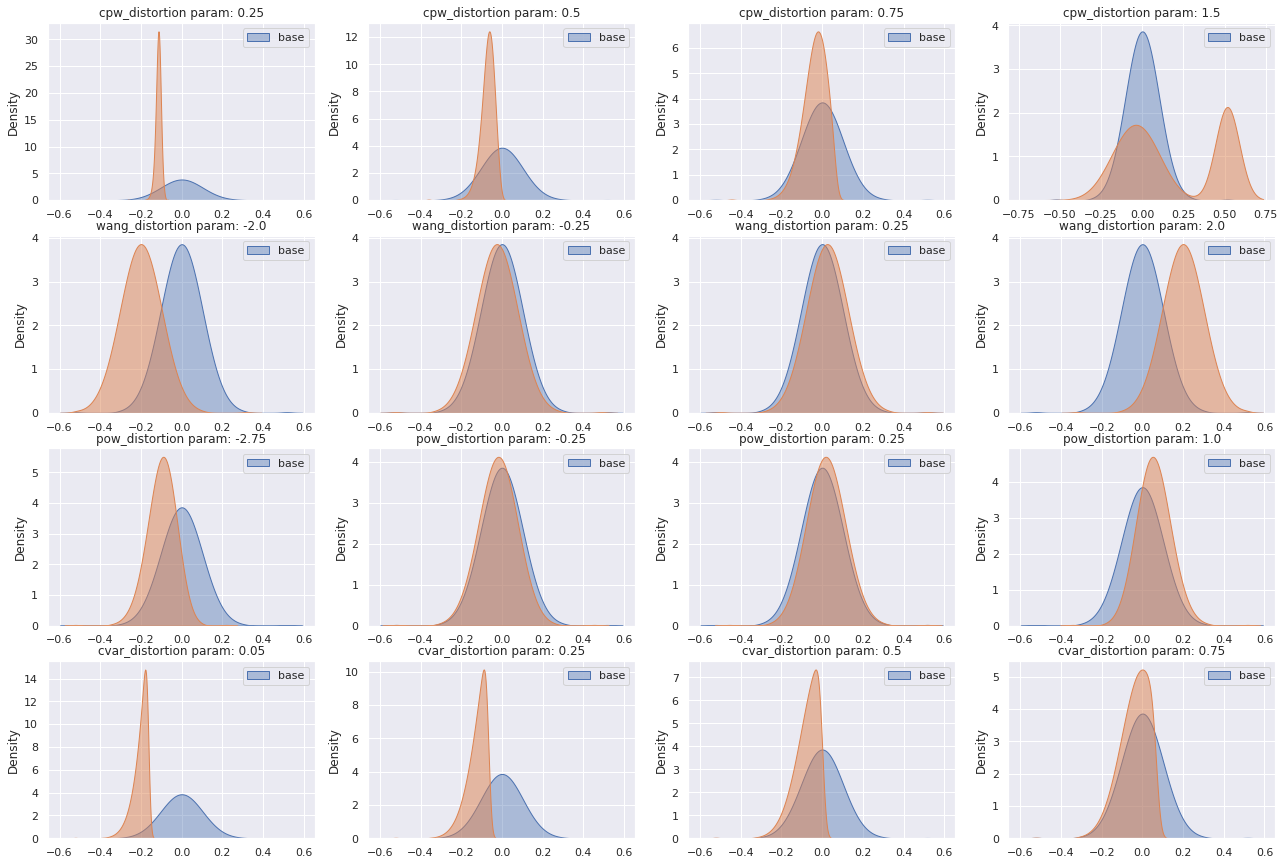

In [27]:
fig, ax = plt.subplots(4, 4, figsize = (22, 15))
_x = dist.icdf(p)
for i, (func, params) in enumerate(((cpw_distortion, (.25, .5, .75, 1.5)), 
                                     (wang_distortion, (-2., -.25, .25, 2.)),
                                    (pow_distortion, (-2.75, -.25, .25, 1.)),
                                    (cvar_distortion, (.05, .25, .5, .75))
                                    )):
    for j, param in enumerate(params):
        distorted = torch.clip(func(param, p), 1e-7, 1-1e-7)
        sns.kdeplot(_x, label='base', alpha=.4, fill=True, ax=ax[i, j])
        sns.kdeplot(dist.icdf(distorted), alpha=.5, fill=True, ax=ax[i, j])
        ax[i, j].set_title(f'{func.__name__} param: {param}')
        ax[i, j].legend()

False